In [1]:
import torch
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Set, Optional, Union, Callable
from kan import KAN, LBFGS

In [2]:
device = torch.device("cuda:0")
print("Using device:", device)

rho = torch.tensor(1.0, device=device)
nu = torch.tensor(0.01, device=device)
eps = torch.tensor(1e-8, device=device)

width, height = 1.0, 1.0
num_points_x, num_points_y = 120, 120

x = torch.linspace(0, width, num_points_x, device=device)
y = torch.linspace(0, height, num_points_y, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1)
coordinates = coordinates.requires_grad_()

#KAN model
#model = KAN(width=[2,16,16, 3], grid=5, k=3, grid_eps=1.0,
#            noise_scale_base=0., device=torch.device('cuda:0')).to(device)

# MLP neural network
class FCNet(torch.nn.Module):
    def __init__(self, num_ins=3,
                 num_outs=3,
                 num_layers=10,
                 hidden_size=50,
                 activation=torch.nn.Tanh):
        super(FCNet, self).__init__()

        layers = [num_ins] + [hidden_size] * num_layers + [num_outs]
        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = activation

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        # Since Chebyshev polynomial is defined in [-1, 1]
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim, 1)).expand(
            -1, -1, self.degree + 1
        )  # shape = (batch_size, inputdim, self.degree + 1)
        # Apply acos
        x = x.acos()
        # Multiply by arange [0 .. degree]
        x *= self.arange
        # Apply cos
        x = x.cos()
        # Compute the Chebyshev interpolation
        y = torch.einsum(
            "bid,iod->bo", x, self.cheby_coeffs
        )  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)
        return y

class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(2, 32, 5)
        self.chebykan2 = ChebyKANLayer(32, 32, 5)
        self.chebykan3 = ChebyKANLayer(32, 3, 5)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        x = self.chebykan3(x)
        return x
        
model = ChebyKAN().to(device)     
#model = FCNet(num_ins=2, num_outs=3, num_layers=2, hidden_size=32).to(device)

Using device: cuda:0


In [3]:
# def batch_jacobian(func, x, create_graph=False):
#     # x in shape (Batch, Length)
#     def _func_sum(x):
#         return func(x).sum(dim=0)
#     return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)


def navier_stokes_residuals(coords):
    y_pred = model(coords)
    # grads = batch_jacobian(model, coords)
    # hess = autograd.functional.hessian(model,coords)
    u, v, p = y_pred[:, 0:1], y_pred[:, 1:2], y_pred[:, 2:3]
    u_xy = autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_xy = autograd.grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    p_xy = autograd.grad(p, coords, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    u_x, u_y = u_xy[:, 0:1], u_xy[:, 1:2]
    v_x, v_y = v_xy[:, 0:1], v_xy[:, 1:2]
    p_x, p_y = p_xy[:, 0:1], p_xy[:, 1:2]

    u_xx = autograd.grad(u_x, coords, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, coords, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    v_xx = autograd.grad(v_x, coords, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = autograd.grad(v_y, coords, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]
    
   

    continuity = u_x + v_y  # Assuming incompressibility (no source/sink terms)
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_xx + v_yy)

    #coords are a Nx2 tensor where each row is [x, y]
    no_slip_mask = (coords[:, 0:1] == 0) |  (coords[:,1:2] == 0) |  (coords[:, 0:1] == width)  # No-slip at left,bottom and right 
    lid_mask = (coords[:, 1:2] == height)  # Top at y = height
    #right_mask = (coords[:, 0] == width)  # Outlet at x = width

    # Applying boundary conditions
    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)  # u and v should be zero
    lid_loss = torch.mean((u[lid_mask] - 1) ** 2 + v[lid_mask] ** 2)  # u should be 1, v should be 0 at inlet
    #outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)  # p should be 0 at outlet

    # Combine all losses
    bc_loss = no_slip_loss + lid_loss 
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + 10.0*bc_loss
    return total_loss



writer = SummaryWriter()


def train():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    steps = 2000
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 5 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)


train()

writer.close()


Step: 1995 | Loss: 0.048: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [19:43<00:00,  1.69it/s]


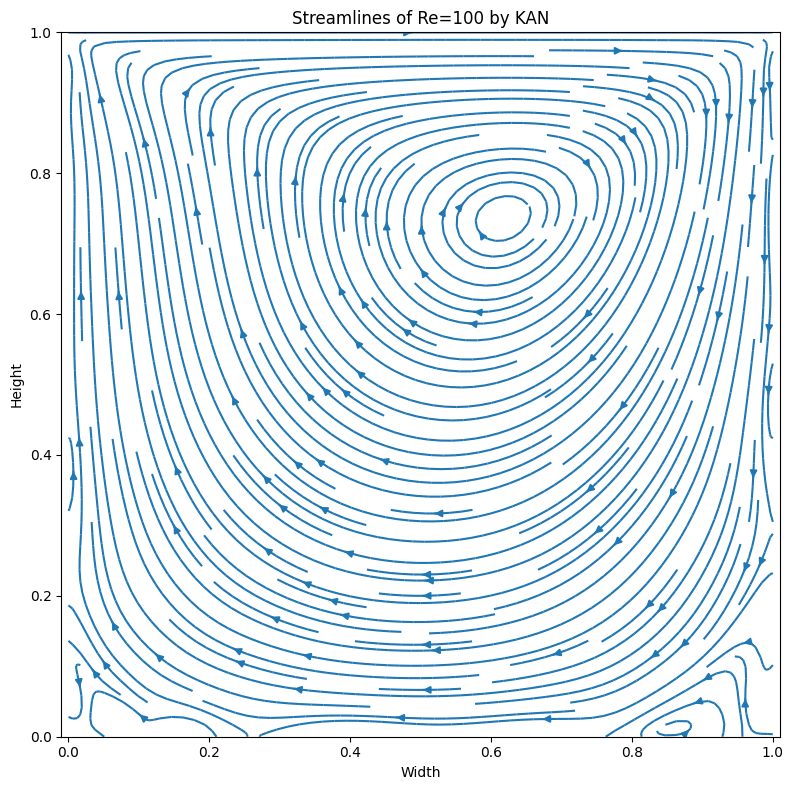

In [4]:
u_pred = model(coordinates)[:, 0].detach().reshape(
    num_points_x, num_points_y).T.cpu()

v_pred = model(coordinates)[:, 1].detach().reshape(
    num_points_x, num_points_y).T.cpu()


#magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2)
Y, X  = np.mgrid[0:width:120j,0:height:120j]
#plt.ylim([0,1])
#ax = plt.gca()
plt.figure(figsize=(8, 8))  # Set the figure size as needed
#plt.imshow(u_pred, extent=(0, width, 0, height), origin='lower', cmap='viridis')
plt.streamplot(X,Y,u_pred,v_pred,density=[2,2])
#plt.colorbar()  # Add a colorbar to show the magnitude scale
plt.title('Streamlines of Re=100 by KAN')
plt.xlabel('Width')
plt.ylabel('Height')

plt.axis('equal')  # Ensure the plot has equal scaling

plt.tight_layout()  # Adjust layout to prevent overlap
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig("cavity200.png")
plt.show()


In [5]:
#model.plot(beta=10)
#plt.savefig("model.png")

In [6]:
torch.save(model.state_ckpt(),"Re100_Lb10_1000.ckpt")

AttributeError: 'ChebyKAN' object has no attribute 'save_ckpt'

In [ ]:
np.shape(u_pred)

In [ ]:
#print(X[:,60])

In [ ]:
#print(Y[:,60])

In [7]:
np.savetxt("X_CKAN.csv",X,delimiter=" ")
np.savetxt("Y_CKAN.csv",Y,delimiter=" ")
np.savetxt("U_CKAN.csv",u_pred,delimiter=" ")
np.savetxt("V_CKAN.csv",v_pred,delimiter=" ")